# Red convolucional Imperative/Training loop
- Objetivo: Programar una CNN en notación orientada a objetos con Tensorflow 2

- Referencia Imperative APIs: https://blog.tensorflow.org/2019/01/what-are-symbolic-and-imperative-apis.html

Los modelos son más personalizables para tareas como investigación

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras



fashion_mnist = keras.datasets.fashion_mnist

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()


In [2]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress',
                   'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


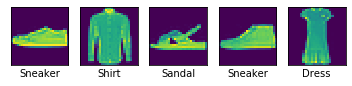

In [3]:
for i in range(5):
    rand_image_idx = np.random.randint(0, y_train.shape[0])
    plt.subplot(1, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid('off')
    plt.imshow(x_train[rand_image_idx])
    plt.xlabel(class_names[y_train[rand_image_idx]])
plt.show()

In [4]:
# escalar entre 0 y 1
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype('float32') / 255
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1).astype('float32') / 255


In [5]:
print(x_train.shape) # (60000, 28, 28, 1)
print(x_test.shape)  # (10000, 28, 28, 1)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


In [6]:
batch_size = 50

train_ds = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)).shuffle(10000).batch(batch_size)

In [7]:
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras import Model

# Crear modelo
- Se tienen que asignar las funciones de activación como 'softmax' en la salida para 'SparseCategoricalCrossentropy'

In [8]:
class CNN(Model):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv = Conv2D(30, 3, activation='relu', name='conv')
        self.pool = MaxPooling2D(2, name='pool')
        self.f = Flatten(name='flatten')
        self.d = Dense(10, activation='softmax', name='dense')

    def call(self, x): # método call que pasa 'x' por capa
        x = self.conv(x)
        x = self.pool(x)
        x = self.f(x)
        return self.d(x)


In [9]:
model = CNN()
model.build( input_shape=(None, 28, 28, 1))
model.summary()

Model: "cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv (Conv2D)                multiple                  300       
_________________________________________________________________
pool (MaxPooling2D)          multiple                  0         
_________________________________________________________________
flatten (Flatten)            multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  50710     
Total params: 51,010
Trainable params: 51,010
Non-trainable params: 0
_________________________________________________________________


- Optimizador y función de costo

In [10]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()

- Métricas

In [11]:
train_loss = tf.keras.metrics.SparseCategoricalCrossentropy(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

- Listas para plot

In [12]:
hist_loss = []
hist_acc = []

## Entrenamiento
- Se hace un ciclo por épocas en donde se itera por cada época sobre cada par de datos y etiquetas de entrenamiento

- *Nota: El entrenamiento con 'tf.function decorator' tiene un mejor desempeño al compilarse en grafo. Para simplificar el ejemplo, también se omite el entrenamiento en conjunto de prueba*

In [13]:
EPOCH = 20
for epoch in range(EPOCH):
    #entrenamiento
    for data, target in train_ds:
        with tf.GradientTape() as tape:
            predictions = model(data)# predicciones
            loss = loss_fn(target, predictions) # target y predicciones para obtener acc
        gradients = tape.gradient(loss, model.trainable_variables) # gradiente sobre variables entrenables
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        # se guardan metricas
        train_loss(target, predictions)
        train_accuracy(target, predictions)
    

    template = 'Epoch {}/{} \n - loss: {} - accuracy: {}'
    print(template.format(epoch+1, EPOCH,
                        train_loss.result(), train_accuracy.result()))
    # lista para plot
    hist_loss.append(train_loss.result())
    hist_acc.append(train_accuracy.result())
    # reinicia las metricas para la siguiente epoca
    train_loss.reset_states()
    train_accuracy.reset_states()

Epoch 1/20 
 - loss: 0.4680822789669037 - accuracy: 0.8371999859809875
Epoch 2/20 
 - loss: 0.32173648476600647 - accuracy: 0.887066662311554
Epoch 3/20 
 - loss: 0.28852158784866333 - accuracy: 0.8992833495140076
Epoch 4/20 
 - loss: 0.26711592078208923 - accuracy: 0.9056000113487244
Epoch 5/20 
 - loss: 0.25134652853012085 - accuracy: 0.9107666611671448
Epoch 6/20 
 - loss: 0.23804430663585663 - accuracy: 0.9157999753952026
Epoch 7/20 
 - loss: 0.22623147070407867 - accuracy: 0.9202166795730591
Epoch 8/20 
 - loss: 0.21565188467502594 - accuracy: 0.9245166778564453
Epoch 9/20 
 - loss: 0.2054499387741089 - accuracy: 0.9273499846458435
Epoch 10/20 
 - loss: 0.1977359801530838 - accuracy: 0.9306333065032959
Epoch 11/20 
 - loss: 0.18901444971561432 - accuracy: 0.9334333539009094
Epoch 12/20 
 - loss: 0.18020057678222656 - accuracy: 0.9372166395187378
Epoch 13/20 
 - loss: 0.17478816211223602 - accuracy: 0.9377833604812622
Epoch 14/20 
 - loss: 0.16748106479644775 - accuracy: 0.94155001

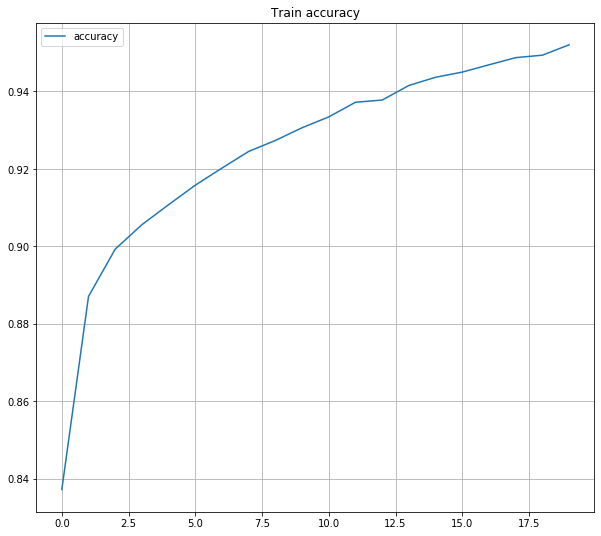

In [14]:
plt.figure(figsize=(10,9))
plt.plot(np.arange(len(hist_acc)), hist_acc)
plt.title('Train accuracy')
plt.legend(['accuracy'])
plt.grid()

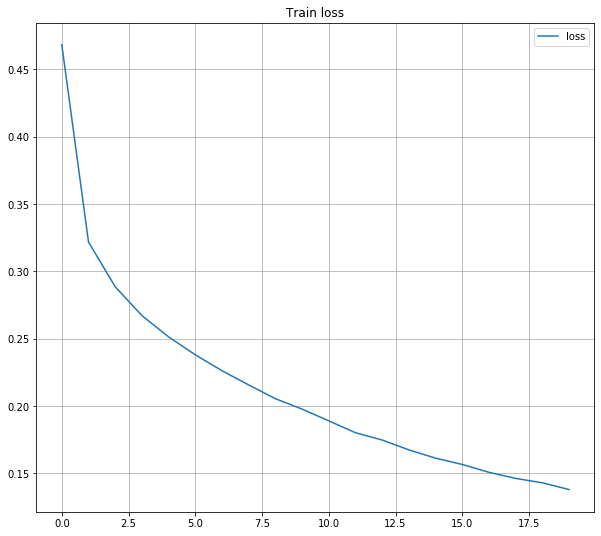

In [15]:
plt.figure(figsize=(10,9))
plt.plot(np.arange(len(hist_loss)), hist_loss)
plt.title('Train loss')
plt.legend(['loss'])
plt.grid()

- Agregar conjunto de validación
- Mejorar la arquitectura
- Personalizar modelo
- Probar con otro dataset